In [185]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import json

In [186]:
def Id(r):
    E=np.eye(3)
    return np.matmul(E,r)

def Cn(r,n,axis):
    '''
    Rotación
    
    r: Array de 3 coordenadas a rotar
    axis: Array de 3 coordenadas que en dirección del eje de rotación. El programa lo transforma en un vector unitario
    automáticamente.
    n: Da un ángulo de rotación theta=2pi/n
    '''
    axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
    ux,uy,uz = axis      #Obtiene las componentes
    sin,cos = (np.around(np.sin(2*np.pi/n),4),np.around(np.cos(2*np.pi/n),4))     #Para simplificar matriz (y redondea los numeros sueltos a 4 decimales)
    
    R=np.array([[cos+np.power(ux,2)*(1-cos), ux*uy*(1-cos)-uz*sin, ux*uz*(1-cos)+uy*sin],
                [uy*ux*(1-cos)+uz*sin, cos+np.power(uy,2)*(1-cos), uy*uz*(1-cos)-ux*sin],
                [uz*ux*(1-cos)-uy*sin, uz*uy*(1-cos)+ux*sin, cos+np.power(uz,2)*(1-cos)]])
    return np.matmul(R,r)
    
def S(r,axis):
    '''
    Reflexión con respecto a un plano con vector normal dado por axis
    
    r: Array de 3 coordenadas 
    axis: Array de 3 coordenadas normal al plano de reflexión. El programa lo transforma en un vector unitario
    automáticamente.
    '''
    axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
    ux,uy,uz = axis      #Obtiene las componentes
    
    R=np.array([[1-2*np.power(ux,2), -2*ux*uy, -2*ux*uz],
               [-2*ux*uy, 1-2*np.power(uy,2), -2*uy*uz],
               [-2*ux*uz, -2*uy*uz, 1-2*np.power(uz,2)]])
    return np.matmul(R,r)

def i(r):
    """
    Inversión con respecto al origen
    
    r: Array de 3 coordenadas 
    """
    return -r

In [187]:
class Molecula (object):
    """
    Clase que representa a la posición y tipo de átomos en una molécula 
    coordenadas y una lista de elementos
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, coords, elements, coords_relative=True):
        """
        Crear una base atómica a partir de una lista de coordenadas y de átomos 
        Se asume por ausencia que las posiciones están dadas en coordenadas relativas
        
        Argumentos:
          coords -> arreglo de coordenadas (vectores)
          elements -> lista de elementos
          coords_relative -> BOOL (True por descarte)
        """
        coor = np.array(coords, dtype=np.float64)
        
        nats = np.shape(coor)[0]
        if ( len(elements) != nats):
            print ('Error: número de elementos y número de átomos (coordenadas) debe ser el mismo')
                   
        self.coords = coor
        self.elements = elements
        self.nats = nats
        self.relative = coords_relative
    
    @property
    def son_relativas(self):
        return self.relative
    
    @property
    def get_number_of_atoms(self):
        return self.nats
    
    def igual_a(self,M):
        '''
        Compara si la molécula es igual a la molécula M
        '''
        numiguales = 0
        for i in range(0, self.nats):
            for j in range(0, M.nats):
                d = self.coords[i]-M.coords[j]
                dist = np.sqrt(sum(d*d))
                if dist < 0.02 and self.elements[i] == M.elements[j]: #Por errores numéricos puede que no queden exactamente igual
                    numiguales+=1   #Los atomos en el mismo lugar y del mismo elemento
                    
        if numiguales == self.nats:
            return True
        else:
            return False
    
    def IdM(self): 
        """
        Crea otra molécula con Id aplicada
        """
        Idcoord = []
        E=np.eye(3)
        for r in self.coords:
            Idcoord.append(np.matmul(E,r))
        return Molecula(Idcoord, self.elements)
    
    def iM(self): 
        """
        Crea otra molécula con i aplicada
        """
        Idcoord = []
        for r in self.coords:
            Idcoord.append(-r)
        return Molecula(Idcoord, self.elements)
        
    def CnM(self, n, axis):
        '''
        Crea otra molécula con Cn aplicada
        
        Axis: Array de 3 coordenadas que en dirección del eje de rotación. El programa lo transforma en un vector unitario
        automáticamente.
        n: Da un ángulo de rotación theta=2pi/n
        '''
        axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
        ux,uy,uz = axis      #Obtiene las componentes
        sin,cos = (np.around(np.sin(2*np.pi/n),4),np.around(np.cos(2*np.pi/n),4))     #Para simplificar matriz (y redondea los numeros sueltos a 4 decimales)
        
        R=np.array([[cos+np.power(ux,2)*(1-cos), ux*uy*(1-cos)-uz*sin, ux*uz*(1-cos)+uy*sin],
                    [uy*ux*(1-cos)+uz*sin, cos+np.power(uy,2)*(1-cos), uy*uz*(1-cos)-ux*sin],
                    [uz*ux*(1-cos)-uy*sin, uz*uy*(1-cos)+ux*sin, cos+np.power(uz,2)*(1-cos)]])
        
        Cncoord = []
        for r in self.coords:
            Cncoord.append(np.matmul(R,r))
        return Molecula(Cncoord, self.elements)
    
    def SM(self, axis):
        '''
        Crea otra molécula con S aplicada
        
        Axis: Array de 3 coordenadas normal al plano de reflexión. El programa lo transforma en un vector unitario
        automáticamente.
        '''
        axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
        ux,uy,uz = axis      #Obtiene las componentes
        
        R=np.array([[1-2*np.power(ux,2), -2*ux*uy, -2*ux*uz],
                   [-2*ux*uy, 1-2*np.power(uy,2), -2*uy*uz],
                   [-2*ux*uz, -2*uy*uz, 1-2*np.power(uz,2)]])
        
        Scoord = []
        for r in self.coords:
            Scoord.append(np.matmul(R,r))
        return Molecula(Scoord, self.elements)
    
    def SnM(self, n, axis):
        '''
        Crea otra molécula con Sn aplicada (rotación impropia, rotación seguida de reflexión por el plano)
        
        Axis: Array de 3 coordenadas que en dirección del eje de rotación. El programa lo transforma en un vector unitario
        automáticamente.
        n: Da un ángulo de rotación theta=2pi/n
        '''
        M = self.CnM(n, axis)
        return M.SM(axis)
        
    
    def Simetria_Id(self):
        """
        Verifica si la molécula es invariante bajo la identidad
        """
        return self.igual_a(self.IdM())
    
    def Simetria_i(self):
        """
        Verifica si la molécula es invariante bajo la inversión con respecto al centro
        """
        return self.igual_a(self.iM())
    
    
    def Simetria_Cn(self, n, axis):
        """
        Verifica si la molécula es invariante bajo Cn
        """
        return self.igual_a(self.CnM(n, axis))
    
    def Simetria_S(self, axis):
        """
        Verifica si la molécula es invariante bajo S
        """
        return self.igual_a(self.SM(axis))
    
    def Simetria_Sn(self, n, axis):
        """
        Verifica si la molécula es invariante bajo Sn
        """
        return self.igual_a(self.SnM(n, axis))
    
    def Grupo_puntual(self, axis_list):
        """
        Busca el grupo puntual
        axis_list es un array de los posibles ejes de simetría no colineales (incluyendo ejes normales a planos de simetría),
        tomando como eje principal el primer elemento de la lista
        Regresa un string con el nombre del grupo
        """
        axis = axis_list[0] #Eje principal de simetría
        if self.Simetria_Cn(10, axis) and self.Simetria_Cn(20, axis) and self.Simetria_Cn(30, axis) and self.Simetria_Cn(40, axis) and self.Simetria_Cn(50, axis):
            #Se checó por simetría de rotación infinita sin que las rotaciones sean muy pequeñas para ser indetectables numéricamente
            if self.Simetria_i():
                return 'D_{inf h}'
            else:
                return 'C_{inf v}'
        else:
            #Checando si tiene 2 o mas ejes de simetría C3
            n=0
            for a in axis_list:
                if self.Simetria_Cn(3, a):
                    n+=1
            if n>=2:
                #Checando si tiene 2 o mas ejes de simetría C5
                n=0
                for a in axis_list:
                    if self.Simetria_Cn(5, a):
                        n+=1
                if n>=2:
                    if self.Simetria_i():
                        return 'I_{h}'
                    else:
                        return 'I'
                else:
                    #Checando si tiene 2 o mas ejes de simetría C4
                    n=0
                    for a in axis_list:
                        if self.Simetria_Cn(4, a):
                            n+=1
                    if n>=2:
                        if self.Simetria_i():
                            return 'O_{h}'
                        else:
                            return 'O'
                    else:
                        #Checando si tiene 2 o mas planos de inversión
                        n=0
                        for a in axis_list:
                            if self.Simetria_S(a):
                                n+=1
                        if n>=2:
                            if self.Simetria_i():
                                return 'T_{h}'
                            else:
                                return 'T_{d}'
                        else:
                            return 'T'
            else:
                #Buscando el orden más grande de simetría Cn, si es que hay alguno (debe ser en el eje principal)
                for n in range(2,12):
                    if self.Simetria_Cn(n, axis):
                        #Checando si hay n simetrías C2 con ejes perpendiculares al principal
                        i=0
                        for a in axis_list: #No importa que incluyamos al principal, pues nunca es ortogonal a sí mismo
                            if self.Simetria_Cn(2, a) and np.dot(axis, a)<=0.01: #Simétrico y ortogonal
                                i+=1
                        if i==n:
                            #Checando si hay plano de reflexión horizontal (eje principal)
                            if self.Simetria_S(axis):
                                return 'D_{'+str(n)+'h}'
                            else:
                                #Checando si hay n planos de reflexión verticales (ortogonales a eje principal)
                                j=0
                                for a in axis_list: #No importa que incluyamos al principal, pues nunca es ortogonal a sí mismo
                                    if self.Simetria_S(a) and np.dot(axis, a)<=0.01: #Simétrico y ortogonal
                                        j+=1
                                if j==n:
                                    return 'D_{'+str(n)+'d}'
                                else:
                                    return 'D_{'+str(n)+'}'
                        elif self.Simetria_S(axis): #No hubo n simetrías C2, checando si hay plano de reflexión horizontal (eje principal)
                            return 'C_{'+str(n)+'h}'
                        else:
                            #Checando si hay n planos de reflexión verticales (ortogonales a eje principal)
                            j=0
                            for a in axis_list: #No importa que incluyamos al principal, pues nunca es ortogonal a sí mismo
                                if self.Simetria_S(a) and np.dot(axis, a)<=0.01: #Simétrico y ortogonal
                                    j+=1
                            if j==n:
                                return 'C_{'+str(n)+'v}'
                            else:
                                #Checando si tiene un eje impropio de rotación S_2n
                                for a in axis_list: #No importa que incluyamos al principal, pues nunca es ortogonal a sí mismo
                                    if self.Simetria_Sn(2*n, a) and np.dot(axis, a)<=0.01: #Simétrico y ortogonal
                                        return 'S_{2'+str(n)+'}'
                                    else:
                                        return 'C_{'+str(n)+'}'
    
                #Termina el for sin que haya simetría Cn hasta el 12 (si intentamos más grande, puede que sea muy pequeña y haya errores numéricos) 
                for a in axis_list: #Checando si hay algún plano de reflexión
                    if self.Simetria_S(a):
                        return 'C_{s}'
                #No hubo planos de reflexión, buscando si hay simetría de inversión por el origen
                if self.Simetria_i():
                    return 'C_{i}'
                else:
                    return 'C_{1}'
                            
    def dibuja_enlaces(self,ax, max_length=0.6):
        nats = self.nats
        coords = self.coords
        for iat in range(nats):
            for jat in range(iat,nats):
                dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                if (dist <= max_length):
                    Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],
                                  [coords[iat,1],coords[jat,1]]
                                  ,[coords[iat,2],coords[jat,2]],'r')
        
         
    def plot(self, ax):
        nats = self.nats
        self.dibuja_enlaces(ax)
        tipos_elem = np.unique(np.array(self.elements))
        for t in tipos_elem: #Para graficar de diferente color cada elemento diferente
            rx = []
            ry = []
            rz = []
            for i in range(self.nats):
                if self.elements[i] == t:
                    rx.append(self.coords[i][0])
                    ry.append(self.coords[i][1])
                    rz.append(self.coords[i][2])
            ax.scatter(np.array(rx), np.array(ry), np.array(rz), s=60)

<IPython.core.display.Javascript object>


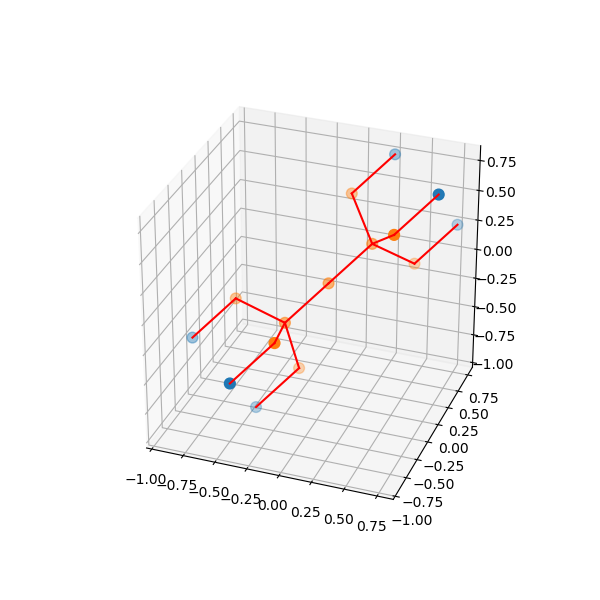

In [188]:
molec1 = Molecula ([[0,0,0],[0.5,0.5,0.0],[0.5,0.0,0.5],[0.0,0.5,0.5],
                     [0.25,0.25,0.25],[0.75,0.75,0.25],[0.75,0.25,0.75],
                      [0.25,0.75,0.75],[-0.17,-0.17,-0.67],[-0.17,-0.67,-0.17],[-0.67,-0.17,-0.17],
                     [-0.25,-0.25,-0.25],[-0.42,-0.42,-0.92],[-0.42,-0.92,-0.42],
                      [-0.92,-0.42,-0.42]],5*['Si']+3*['O']+4*['Si']+3*['O'])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
molec1.plot(ax)
plt.show()

In [189]:
molec1.Simetria_Id()

True

In [190]:
molec1.Simetria_i()

False

In [191]:
molec1.Simetria_Cn(3,np.array([1,1,1]))

True

In [192]:
molec1.Simetria_S(np.array([1,1,1]))

True

In [193]:
molec1.Simetria_Sn(3, np.array([1,1,1]))

True

In [194]:
molec1.Grupo_puntual(np.array([[1,1,1],[0.25,-0.5,0.25],[-0.5,0.25,0.25],[0.25,0.25,-0.5]]))

'D_{3h}'

<IPython.core.display.Javascript object>


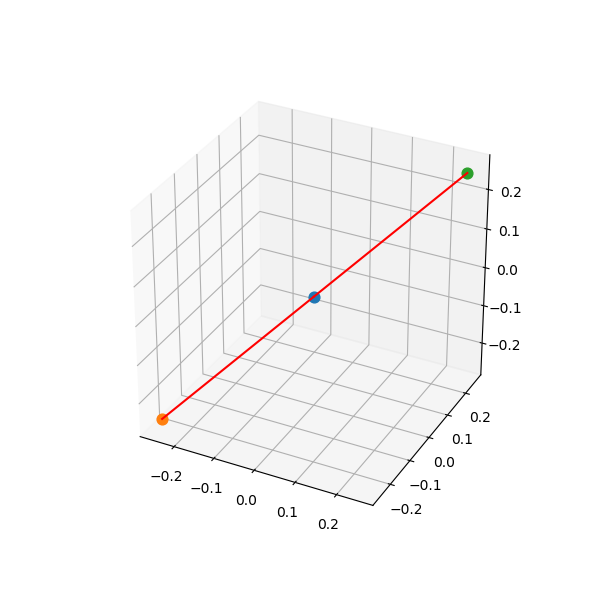

In [195]:
molec2 = Molecula ([[-0.25,-0.25,-0.25],[0,0,0],[0.25,0.25,0.25]],['H','C','N']) #Hydrogen cyanide

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
molec2.plot(ax)
plt.show()

In [196]:
molec2.Grupo_puntual(np.array([[1,1,1],[0.25,-0.5,0.25],[-0.5,0.25,0.25],[0.25,0.25,-0.5]]))

'C_{inf v}'

<IPython.core.display.Javascript object>


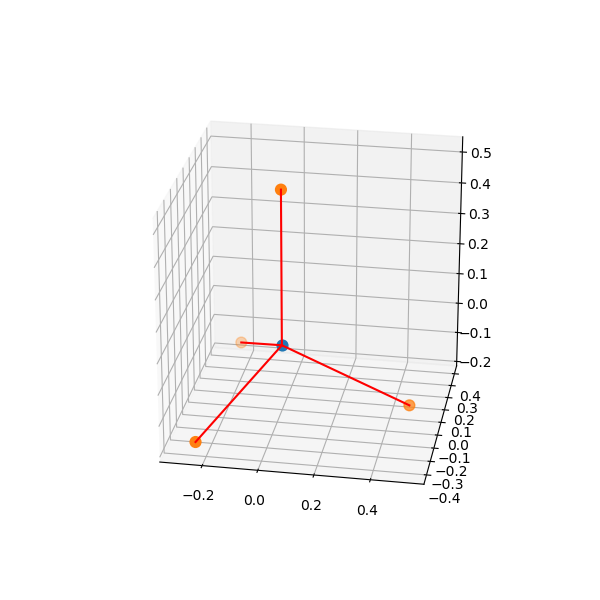

In [197]:
#Methane
molec3 = Molecula ([[0,0,0],[0,0,0.5],[0.4713,0,-0.1669],[-0.23565,0.4081458,-0.1669],[-0.23565,-0.4081458,-0.1669]],['C']+4*['H'])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal','datalim')
molec3.plot(ax)
plt.show()

In [198]:
molec3.Simetria_Cn(3,np.array([0,0,1]))

True

In [199]:
molec3.Simetria_Cn(3,np.array([0.4713,0,-0.1669]))

True

In [200]:
molec3.Grupo_puntual(np.array([[0,0,0.5],[0.4713,0,-0.1669],[-0.23565,0.4081458,-0.1669],[-0.23565,-0.4081458,-0.1669],[0,1,0],[-0.866,-0.5,0],[0.866,-0.5,0]]))

'T_{d}'